[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RikVoorhaar/optimization-II-2021/blob/master/notebooks/week3.ipynb)

# Week 3

This is the first Python programming homework for this course. You can do this homework either on Google colab, or on your own machine (after installing conda). You might also want to look back at the week 0 notebook, and go through it to get better accostumed to Jupyter notebooks. Some general instructions for the exercises:

- In the description of every exercise we mention which functions you should use, and there will be a link to the relevant documentation. You are strongly encouraged to read the documentation, especially if you are not sure what the function does. 

- Each exersice consists of finishing some partially written code. The code you wrote is then automatically tested using a few `assert` statements. This is for your convenience, and you are requested __not to alter the tests__. If your code conforms to the instructions, and none of the tests throw an error, there is a good chance that your answer is correct. 

- It is possible to solve each exercise in no more than 10 lines of code, and most only need 2-3 lines. If your solution is much longer, you should try to make it shorter. In particular, don't forget that using vectorized `numpy` and `scipy` functions tends to produce shorter and much faster code than using nested Python `for` loops. 

- Before handing in, be sure to restart the IPython kernel (in colab: Runtime $\to$ Run all) and run the entire notebook top-to-bottom and check that none of the cells throw an error. 

Now we begin by running the cell below. Google colab by default uses an outdated version of CVXPY, and so we will need to update it. This may take about a minute, but this update is only performed once per session. If you're running this notebook on a local python installation, make sure that this cell does not throw any errors. If it does, you will need to install additional packages. You can do this by using `pip` from the command line.

In [1]:
from importlib_metadata import version

if version('cvxpy')<'1.1.0':
    !pip install --upgrade cvxpy
import cvxpy as cp
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (9, 6)
import numpy as np
import pandas as pd
import scipy

## Exercise 1
The aim of this exercise is to use `cvxpy` for polynomial approximation of functions or data.

Given two positive integers $N,d\in\mathbb{N}$ we want to learn a polynomial $P_c\colon \mathbb R\to \mathbb R$ of degree $d$ with coefficients $c=(c_0,c_1,\dots,c_d)^T \in \mathbb R^{d+1}$:
$$
    P_c(x) = \sum_{i=0}^d c_i x^i.
$$

Given $N$ training values of $X = (x_1,\dots,x_N)^T$ and $Y = (y_1,\dots,y_N)^T$,  we consider the minimization problem
$$
\min_{c\in\mathbb{R}^{d+1}}\left\|P_c(X)-Y\right\|\tag{1}
$$

for a suitable vector norm $\left\|\cdot\right\|$  and by abuse of notation, $P_c(X) = (P_c(x_1),\dots,P_c(x_N))^T$.

### Exercise 1a)
Consider the case $\left\|\cdot\right\|=\left\|\cdot\right\|_2$. We can then rewrite this problem as a least-squares problem by writing
$$
P_c(X) = V_d(X)c
$$

where $V_d(X)$ is the $N\times (d+1)$ Vandermonde matrix
$$
V_d(X) = \begin{pmatrix}
1 & x_1 & x_1^2 & \dots & x_1^d\\
1 & x_2 & x_2^2 & \dots & x_2^d\\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_N & x_N^2 & \dots & x_N^d
\end{pmatrix}.
$$

___
> Write a function `vandermonde(X,d)` that creates $V_d(X)$. Make sure the final result is a numpy array.
>
>You are _not_ allowed to use the numpy function `np.vander`, the point is to implement this yourself. 

___

Tips

- You can use [np.stack](https://numpy.org/doc/stable/reference/generated/numpy.stack.html) to turn a list of vectors into a matrix.
- You can raise the elements of an array `A` to the power `i` by `A**i`
- You can use `np.array(A)` to cast Python lists to numpy arrays. 
- You can transpose a matrix `A` using `A.T`

In [2]:
def vandermonde(X, d):
    columns = []
    for i in range(d + 1):
        columns.append(X ** i)
    return np.stack(columns, axis=1)
    # Alternative: return np.array(columns).T


# Print the vandermonde array for X regularly sampled from -1 to 1
np.set_printoptions(
    edgeitems=30, linewidth=100, formatter=dict(float=lambda x: "%+.5f" % x)
)
X = np.linspace(-1, 1, 10)
V_X = vandermonde(X, 4)
print(V_X)

# Tests
assert isinstance(V_X, np.ndarray), "The result is not a numpy array"
assert V_X.shape == (10, 5), "The shape of the result is incorrect"
assert vandermonde(np.linspace(-1, 1, 6), 2).shape == (
    6,
    3,
), "The shape of the result is incorrect"
assert np.linalg.norm(V_X[:, 0] - np.ones(10)) < 1e-8, "The result is not correct"
assert np.abs(np.mean(V_X) - 0.3404298) < 1e-4, "The result is not correct"

[[+1.00000 -1.00000 +1.00000 -1.00000 +1.00000]
 [+1.00000 -0.77778 +0.60494 -0.47051 +0.36595]
 [+1.00000 -0.55556 +0.30864 -0.17147 +0.09526]
 [+1.00000 -0.33333 +0.11111 -0.03704 +0.01235]
 [+1.00000 -0.11111 +0.01235 -0.00137 +0.00015]
 [+1.00000 +0.11111 +0.01235 +0.00137 +0.00015]
 [+1.00000 +0.33333 +0.11111 +0.03704 +0.01235]
 [+1.00000 +0.55556 +0.30864 +0.17147 +0.09526]
 [+1.00000 +0.77778 +0.60494 +0.47051 +0.36595]
 [+1.00000 +1.00000 +1.00000 +1.00000 +1.00000]]


### Exercise 1b)

Let us now approximate the function
$$
f(x)=\sin\left(2\pi x\right)+3\cos\left(2\pi x^2\right)\,
$$

on the interval $[-1,1]$. Given the values
$$
y_i=f(x_i)\,,\quad i=1,\ldots,n
$$

solve the problem $(1)$ in the following three different ways:  

___
> Write three functions that each take data `X`, `Y` and the degree of the polynomial `d` to solve $(1)$. As first step, apply `vandermonde` or [np.vander](https://numpy.org/doc/stable/reference/generated/numpy.vander.html?highlight=vander) to the data `X`.

> 1. A function `pol_fit_lstsq(X,Y,d)` that solves $(1)$ by regarding it as a least-squares problem as in [Exercise 5 of week 2](https://optimization-ii-2021.readthedocs.io/en/latest/nblinks/week2.html#Exercise-5). Use [np.linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html).

> 2. A function `pol_fit_qr(X,Y,d)` that solves $(1)$ by using the QR factorization ([np.linalg.qr](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html)) of the Vandermonde matrix $V_d(X) = QR$. Recall that $Q$ is orthogonal, and $R$ is upper triangular. Then use a solver specialized for triangular matrices [scipy.linalg.solve_triangular](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html) to solve the transformed problem:
$\min_{c\in \mathbb{R}^n}\|V_d(X)c-Y\| = \min_{c\in \mathbb{R}^n}\|Rc-Q^\top Y\|$

> 3. A function `pol_fit_cvxpy(X,Y,d)` that solves $(1)$ by using CVXPY and regarding the problem as a convex minimization problem.  

___

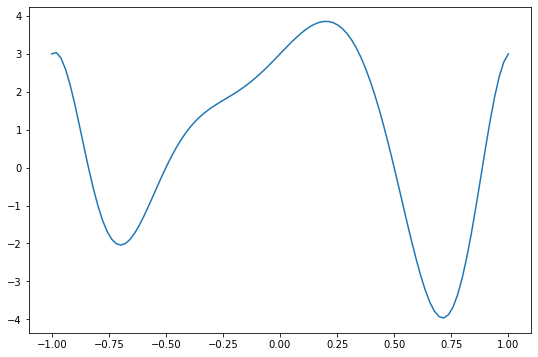

In [3]:
# To get started, we define the function `f` and plot it.
# We also form the data vectors `X` and `Y`.
def f(x):
    return np.sin(2 * np.pi * x) + 3 * np.cos(2 * np.pi * x ** 2)


# This implements the function P_c
def apply_poly(X, c):
    A = np.vander(X, N=len(c), increasing=True)
    return A @ c


N = 100
X = np.linspace(-1, 1, N)
Y = f(X)

plt.plot(X, Y);

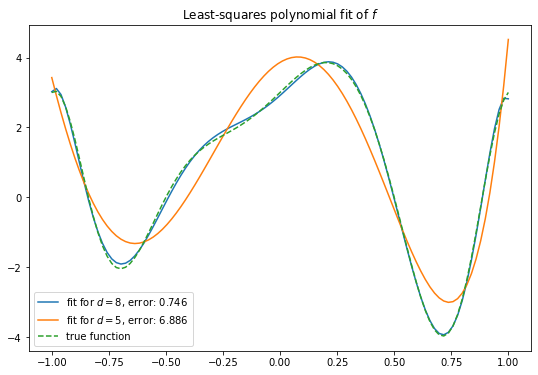

In [4]:
def pol_fit_lstsq(X, Y, d):
    # Read the instructions, because here it's important
    # that the solution is calculated in the right way!
    # Unfortunately it's hard to write tests that
    # check HOW a solution is computed.

    A = vandermonde(X, d)
    c = np.linalg.lstsq(A, Y, rcond=-1)[0]
    return c


# Tests
c5 = pol_fit_lstsq(X, Y, 5)
c8 = pol_fit_lstsq(X, Y, 8)
assert isinstance(c5, np.ndarray), "Make sure the result is a numpy array"
assert c5.shape == (6,), "The shape of the result is wrong"
assert c8.shape == (9,), "The shape of the result is wrong"

Y_pred5 = apply_poly(X, c5)
Y_pred8 = apply_poly(X, c8)
error5 = np.linalg.norm(Y - Y_pred5)
error8 = np.linalg.norm(Y - Y_pred8)

plt.title("Least-squares polynomial fit of $f$")
plt.plot(X, Y_pred8, "-", label=f"fit for $d=8$, error: {error8:.3f}")
plt.plot(X, Y_pred5, "-", label=f"fit for $d=5$, error: {error5:.3f}")
plt.plot(X, Y, "--", label="true function")
plt.legend()

assert np.abs(error5 - 6.88594) < 1e-4, "The error for d=5 is not correct"
assert np.abs(error8 - 0.74568) < 1e-4, "The error for d=5 is not correct"

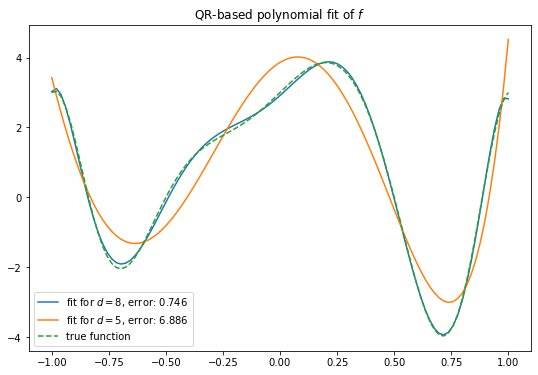

In [5]:
def pol_fit_qr(X, Y, d):
    # Read the instructions, because here it's important
    # that the solution is calculated in the right way!
    # Unfortunately it's hard to write tests that
    # check HOW a solution is computed.

    A = vandermonde(X, d)
    Q, R = np.linalg.qr(A)
    return scipy.linalg.solve_triangular(R, Q.T @ Y)


c5 = pol_fit_qr(X, Y, 5)
c8 = pol_fit_qr(X, Y, 8)
assert isinstance(c5, np.ndarray), "Make sure the result is a numpy array"
assert c5.shape == (6,), "The shape of the result is wrong"
assert c8.shape == (9,), "The shape of the result is wrong"

Y_pred5 = apply_poly(X, c5)
Y_pred8 = apply_poly(X, c8)
error5 = np.linalg.norm(Y - Y_pred5)
error8 = np.linalg.norm(Y - Y_pred8)

plt.title("QR-based polynomial fit of $f$")
plt.plot(X, Y_pred8, "-", label=f"fit for $d=8$, error: {error8:.3f}")
plt.plot(X, Y_pred5, "-", label=f"fit for $d=5$, error: {error5:.3f}")
plt.plot(X, Y, "--", label="true function")
plt.legend()

assert np.abs(error5 - 6.88594) < 1e-4, "The error for d=5 is not correct"
assert np.abs(error8 - 0.74568) < 1e-4, "The error for d=5 is not correct"

To use CVXPY, we need to define $c$ as a `c=cp.Variable(d+1)` of size $d+1$. Then we need to define the minimization problem for $c$, and instruct to solve it.
For the minimization problem, use `cp.Problem`, `cp.minimize` and `cp.norm`. Recall that in Python we can define matrix-matrix or matrix-vector mutliplication of `A` and `v` by `A @ v`. To solve a problem `problem`, we run `problem.solve()`. After solving the problem, we can obtain the optimal value of `c` by calling `c.value`. 

For a more detailed introduction, read [this tutorial page of CVXPY](https://www.cvxpy.org/tutorial/intro/index.html). 

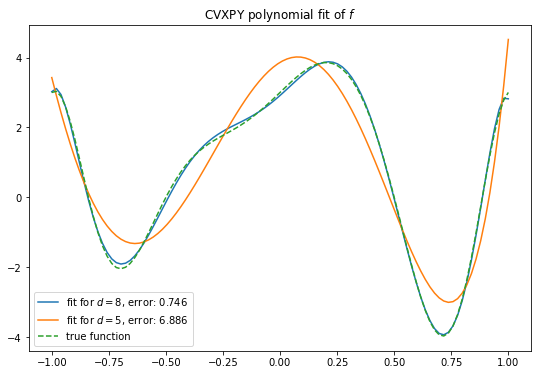

In [6]:
def pol_fit_cvxpy(X, Y, d):
    # Read the instructions, because here it's important
    # that the solution is calculated in the right way!
    # Unfortunately it's hard to write tests that
    # check HOW a solution is computed.

    A = vandermonde(X, d)
    c = cp.Variable(d + 1)
    problem = cp.Problem(cp.Minimize(cp.norm(A @ c - Y, p=2)))
    problem.solve()
    return c.value


# Tests
c5 = pol_fit_cvxpy(X, Y, 5)
c8 = pol_fit_cvxpy(X, Y, 8)
assert isinstance(c5, np.ndarray), "Make sure the result is a numpy array"
assert c5.shape == (6,), "The shape of the result is wrong"
assert c8.shape == (9,), "The shape of the result is wrong"

Y_pred5 = apply_poly(X, c5)
Y_pred8 = apply_poly(X, c8)
error5 = np.linalg.norm(Y - Y_pred5)
error8 = np.linalg.norm(Y - Y_pred8)

plt.title("CVXPY polynomial fit of $f$")
plt.plot(X, Y_pred8, "-", label=f"fit for $d=8$, error: {error8:.3f}")
plt.plot(X, Y_pred5, "-", label=f"fit for $d=5$, error: {error5:.3f}")
plt.plot(X, Y, "--", label="true function")
plt.legend()

assert np.abs(error5 - 6.88594) < 1e-4, "The error for d=5 is not correct"
assert np.abs(error8 - 0.74568) < 1e-4, "The error for d=5 is not correct"

---

Benchmarking and profiling is easy in a Jupyter notebook. Let's compare the speed of the three methods. Using the IPython magic command `%timeit` (yes, they are really called 'magic').

We can quickly compare the speed of each method. We see that the method using a least-squares solver is the fastest, and CVXPY is the slowest. This says nothing about the numerical stability of each method however. In addition, CVXPY can solve many more problems (as you will see below!) Running this cell can take a few seconds, since it runs each method hundreds or thousands of times.

In [7]:
print("Least-squares:")
%timeit pol_fit_lstsq(X,Y,5)

print("\nQR:")
%timeit pol_fit_qr(X,Y,5)

print("\nCVXPY:")
%timeit pol_fit_cvxpy(X,Y,5)

Least-squares:
66.5 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

QR:
105 µs ± 473 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

CVXPY:
4.85 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Exercise 1c)

We can easily change the norm used in the function `pol_fit_cvxpy`. Recall that the 1-norm is more robust to outliers than the 2-norm when fitting functions to data. Here we can compare the two.

___
> Modify `pol_fit_cvxpy` to accept an optional argument `p` with default value `p=2` that changes which norm is used. 
> 
> Make a polynomial fit to the data below using $p=1$ and $p=2$. Do this for $d=4$. 
>
> Plot the results, together with the data $X,y$.

___

Tips:  
- Look at the CVXPY documentation of [cp.norm](https://www.cvxpy.org/api_reference/cvxpy.atoms.other_atoms.html#cvxpy.atoms.norm.norm)  
- Be sure to add labels to all your plots to make it easier to see which line is which. Don't forget to call `plt.legend()`.   

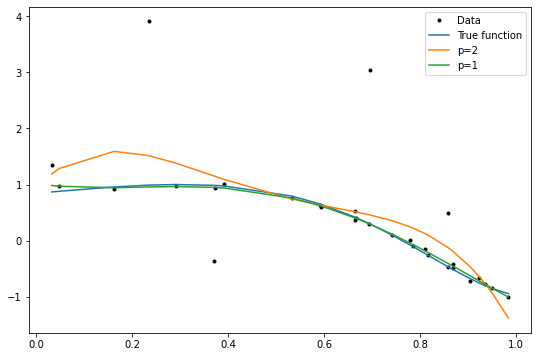

In [8]:
# For reproducibility so that we have the same random numbers.
np.random.seed(179)

# The function we will try to fit
def f(x):
    return np.sin(np.exp(1.5 * x))


# Create X with N uniform random values on [0,1]
N = 30
n_outliers = 5
X = np.random.uniform(size=N)
X = np.sort(X)  # Sort for plotting purposes

# Y is f(X) plus small random noise
# Additionally, choose `n_outliers` entries and perturb them
# with uniform noise
Y = f(X) + np.random.normal(scale=0.05, size=N)
outliers = np.random.choice(N, size=n_outliers)
Y[outliers] += np.random.uniform(low=-3, high=3, size=n_outliers)

plt.plot(X, Y, ".", label="Data", c="k")
plt.plot(X, f(X), label="True function")


def pol_fit_cvxpy(X, Y, d, p=2):
    A = vandermonde(X, d)
    c = cp.Variable(d + 1)
    problem = cp.Problem(cp.Minimize(cp.norm(A @ c - Y, p=p)))
    problem.solve()
    return c.value


c_d4_p2 = pol_fit_cvxpy(X, Y, 4, p=2)
Y_d4_p2 = apply_poly(X, c_d4_p2)
plt.plot(X, Y_d4_p2, label="p=2")

c_d4_p1 = pol_fit_cvxpy(X, Y, 4, p=1)
Y_d4_p1 = apply_poly(X, c_d4_p1)
plt.plot(X, Y_d4_p1, label="p=1")
plt.legend()

## Exercise 2

Suppose that we observe some finite discrete signal $y\in \mathbb R^n$ that is a convolution of two signals and some noise: $y = k*x_0+\epsilon$.

Given that we know $k$ and $y$, we want to recover $x_0$. We can write the convolution product $k*x = Kx$ with $K$ the _convolution matrix_ associated to $k$. Suppose furthermore that the original signal is supported on $[0,1]$. 

This leads to the following minimization problem:

$$
\min_{x\in\mathbb R^N} \|Kx -y\|,\qquad \text{subject to }\,0\leq x_i\leq 1,\quad\forall \,1\leq i\leq N\tag{2}
$$

___
> 1. Write a function `deconvolution_lstsq(K,Y)` that aims to solve $(2)$ by finding the least-squares solution using [np.linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html). You actually cannot solve $(2)$ this way since you cannot incorporate the constraints. However, we can just clip the results to $[0,1]$ after solving the unconstrained problem. Note also that $K$ can have a very large condition number, so this doesn't necessarily give a good solution.
> 2. We note that $K$ is a [circulant matrix](https://en.wikipedia.org/wiki/Circulant_matrix), and this structure can be exploited to solve $(2)$ more efficiently and with higher numerical stability. Write a function `deconvolution_circulant(K,Y)` that solves $(2)$ by using [scipy.linalg.solve_circulant](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_circulant.html).  As before, this solves the unconstrained version of $(2)$, and we will still need to clip the result.
> 3. Write a function `deconvolution_CVXPY(K,Y)` that solves $(2)$ by using CVXPY.

___

Useful functions:   
- [np.clip](https://numpy.org/doc/stable/reference/generated/numpy.clip.html)

Condition number of K: 1.4268e+05



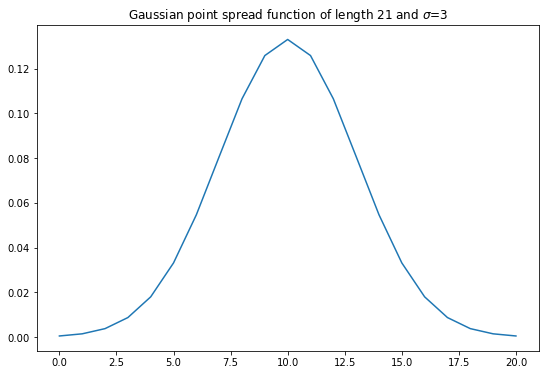

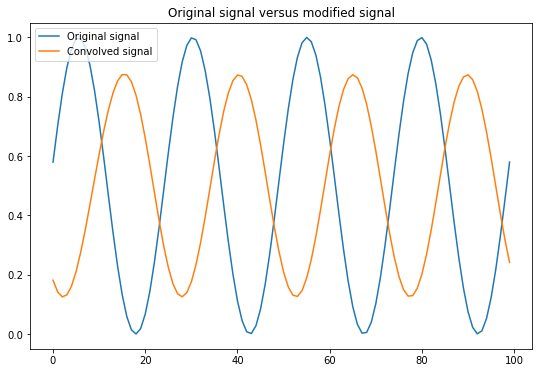

In [9]:
np.random.seed(179)
N = 100
sigma = 3
len_k = 21

# This function implements a Gaussian point spread function to use for convolutioin
# This is a one-dimensional analogue of lens blur (a camera out of focus)
def gaussian_psf(len_k, sigma=1):
    k = np.arange(len_k) - (len_k - 1) // 2
    k = np.exp(-(k ** 2) / (2 * sigma ** 2))
    k = np.abs(k)
    k = k / np.sum(k)
    return k


# Convolution with k
k = gaussian_psf(len_k, sigma)
K = scipy.linalg.circulant(
    np.pad(k, (0, N - len(k)))
)  # Form circulant convolution matrix, pad to make the right shape
print(f"Condition number of K: {np.linalg.cond(K):.4e}\n")

# Plot k
plt.title(f"Gaussian point spread function of length {len_k} and $\sigma$={sigma}")
plt.plot(k)
plt.figure()


# Fast changing sinusoid
X0 = np.linspace(0, 2 * np.pi, N)
X0 = np.sin(0.16 + X0 * 4) / 2 + 0.5

# Y is convolution of k and X0 plus noise
Y = K @ X0 + np.random.normal(scale=1e-5, size=N)

# plot the original and convoluted signal, note the phase shift
plt.title("Original signal versus modified signal")
plt.plot(X0, label="Original signal")
plt.plot(Y, label="Convolved signal")
plt.legend();

mean squared error: 0.02384539632589385


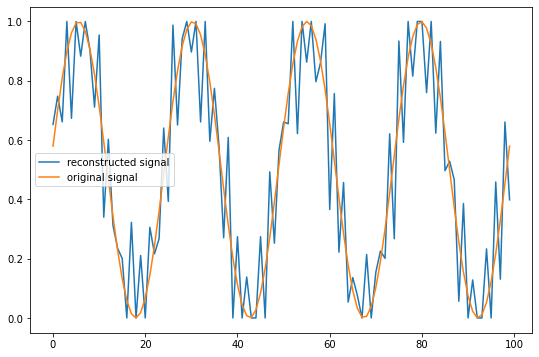

In [10]:
def deconvolution_lstsq(K, Y):
    X = np.linalg.lstsq(K, Y, rcond=-1)[0]
    X = np.clip(X, 0, 1)
    return X


X_linsolve = deconvolution_lstsq(K, Y)
error = np.mean((X0 - X_linsolve) ** 2)
print("mean squared error:", error)

# Plot original and reconstructed signal
plt.plot(X_linsolve, label="reconstructed signal")
plt.plot(X0, label="original signal")
plt.legend()

# Tests
assert X_linsolve.shape == (N,), "The shape of the result is wrong"
assert (
    np.max(X_linsolve) <= 1.0
), "Don't forget to clip the results to satisfy the constraints"
assert (
    np.min(X_linsolve) >= 0.0
), "Don't forget to clip the results to satisfy the constraints"
assert np.abs(error - 0.023845396) < 1e-4, "Check your method"

mean squared error: 0.02384539632741818


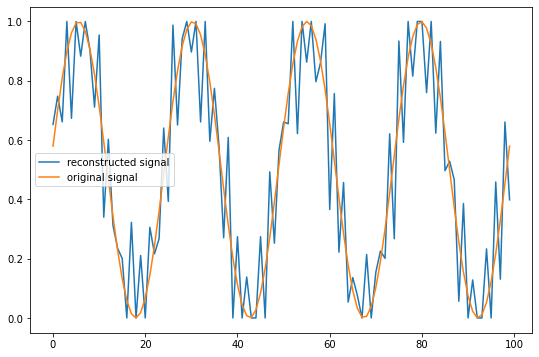

In [11]:
def deconvolution_circulant(K, Y):
    X = scipy.linalg.solve_circulant(K[:, 0], Y)
    X = np.clip(X, 0, 1)
    return X


X_circ_solve = deconvolution_circulant(K, Y)
error = np.mean((X0 - X_circ_solve) ** 2)
print("mean squared error:", error)

# Plot original and reconstructed signal
plt.plot(X_circ_solve, label="reconstructed signal")
plt.plot(X0, label="original signal")
plt.legend()

# Tests
assert X_circ_solve.shape == (
    N,
), "The shape of the result is wrong. Be sure to pass only the first row / column of K to `solve_circulant`"
assert (
    np.max(X_circ_solve) <= 1.0
), "Don't forget to clip the results to satisfy the constraints"
assert (
    np.min(X_circ_solve) >= 0.0
), "Don't forget to clip the results to satisfy the constraints"
assert np.abs(error - 0.02384539) < 1e-4, "Check your method"

mean squared error: 0.0010873684705943886


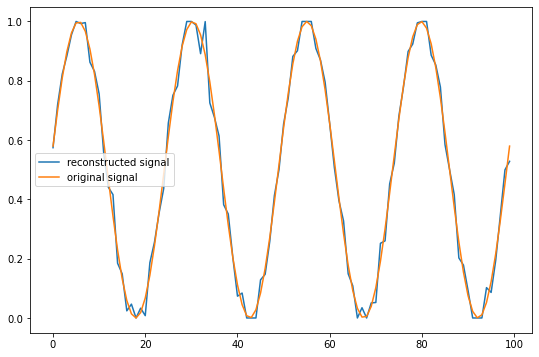

In [12]:
def deconvolution_cvxpy(K, Y):
    N = K.shape[1]
    X = cp.Variable(N)
    objective = cp.Minimize(cp.norm(K @ X - Y))
    constraints = [0 <= X, X <= 1]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return X.value


X_cvxpy = deconvolution_cvxpy(K, Y)
error = np.mean((X0 - X_cvxpy) ** 2)
print("mean squared error:", error)

# Plot original and reconstructed signal
plt.plot(X_cvxpy, label="reconstructed signal")
plt.plot(X0, label="original signal")
plt.legend()

# Tests
assert X_cvxpy.shape == (
    N,
), """The shape of the result is wrong. Be sure to pass only the first row /
column of K to `solve_circulant`"""
assert (
    np.max(X_cvxpy) <= 1.0
), "Don't forget to clip the results to satisfy the constraints"
assert (
    np.min(X_cvxpy) >= 0.0
), "Don't forget to clip the results to satisfy the constraints"
assert np.abs(error - 0.0010873684) < 1e-4, "Check your method"

## Exercise 3
Accordingly to the Italian Department of Public Health, a complete diet should include daily at least the quantity of essential nutrients reported in the Dataframe below as DRI (Daily Reference Intake). Assume that you can compose your diet buying the following foods listed in the Dataframe. 

In [13]:
nutrients = pd.DataFrame(
    index=[
        "Vitamin A",
        "Vitamin B1",
        "Vitamin C",
        "Calcium",
        "Iron",
        "Phosphorus",
        "Potassium",
        "Total fat",
        "Carbohydrates",
        "Proteins",
    ]
)
nutrients["DRI"] = [800, 1.1, 80, 800, 14, 700, 2000, 70, 260, 50]
nutrients["Chicken Breast"] = [0, 0.1, 0, 4, 0.40, 210, 370, 0.8, 0, 23.3]
nutrients["Milk"] = [37, 0.04, 1, 119, 0.1, 93, 150, 3.6, 4.9, 3.3]
nutrients["Pasta"] = [0, 0, 0, 22, 1.4, 189, 192, 1.4, 79.1, 10.9]
nutrients["Beans"] = [3, 0.4, 3, 135, 8, 450, 1445, 2, 47.5, 23.6]
nutrients["Oranges"] = [71, 0.06, 50, 49, 0.2, 22, 200, 0.2, 7.8, 0.7]
nutrients

,DRI,Chicken Breast,Milk,Pasta,Beans,Oranges
Vitamin A,800.0,0.0,37.00,0.0,3.0,71.00
Vitamin B1,1.1,0.1,0.04,0.0,0.4,0.06
Vitamin C,80.0,0.0,1.00,0.0,3.0,50.00
Calcium,800.0,4.0,119.00,22.0,135.0,49.00
Iron,14.0,0.4,0.10,1.4,8.0,0.20
Phosphorus,700.0,210.0,93.00,189.0,450.0,22.00
Potassium,2000.0,370.0,150.00,192.0,1445.0,200.00
Total fat,70.0,0.8,3.60,1.4,2.0,0.20
Carbohydrates,260.0,0.0,4.90,79.1,47.5,7.80
Proteins,50.0,23.3,3.30,10.9,23.6,0.70


The unitary price (CHF $/100$ g) of the goods is reported in the following table

In [14]:
cost = pd.DataFrame(
    data={"cost": [2.85, 0.18, 0.2, 0.5, 0.15]}, index=nutrients.columns[1:]
)
cost

,cost
Chicken Breast,2.85
Milk,0.18
Pasta,0.20
Beans,0.50
Oranges,0.15


___

> Using CVX and assuming that you want to consume _at least_ $10$g of each of the reported goods:
> 
> 1. Find the optimal combination of ingredients such that the total cost is minimized and the diet
satisfies the Dietary Reference Intake;
> 2. In a mass gain diet, the ratio between the amount of proteins and  carbohydrates
should be bigger than $3/5$. Minimize the cost of a mass gain diet in order to fulfill the DRI
constraints.

___

Below we define three variable:  
- `A` is a $10\times 5$ array with nutrition values  
- `b` is a length $10$ vector with DRI values  
- `c` is a length $5$ vector of cost values  

For both subproblems, use `x` as the `cp.Variable` we want to optimize, and `problem` for the `cp.Problem` we will solve. Do not forget to add the right constraints.

In [15]:
A = nutrients.drop("DRI", axis=1).to_numpy()
b = nutrients["DRI"].to_numpy()
c = cost.to_numpy()

# First problem
x = cp.Variable(5)
objective = cp.Minimize(c.T @ x)
constraints = [x >= 0.1, A @ x >= b]
prob = cp.Problem(objective, constraints)
prob.solve()

# Tests
assert x.value is not None, "No solution was found"
assert len(x.value) == 5, "The variable has the wrong shape"
print(f"total price: CHF {np.dot(c.reshape(-1),x.value):.2f}")

assert np.min(x.value) >= 0.1, "Don't forget the minimum amount constraint"
assert np.abs(np.sum(x.value) - 22.49610) < 1e-4, "The value is incorrect"

total price: CHF 4.69


For the second part, we define two useful indices  
- `i1` the row number of A describing proteins  
- `i2` the row number of A describing carbohydrates  

In [16]:
i1 = nutrients.index.get_loc("Proteins")
i2 = nutrients.index.get_loc("Carbohydrates")

constraints = [x >= 0.1, A @ x >= b, A[i1] @ x >= 3 / 5 * A[i2] @ x]
prob = cp.Problem(objective, constraints)
prob.solve()

assert x.value is not None, "No solution was found"
assert len(x.value) == 5, "The variable has the wrong shape"
print(f"total price: CHF {np.dot(c.reshape(-1),x.value):.2f}")

assert np.min(x.value) >= 0.1, "Don't forget the minimum amount constraint!"
assert np.abs(np.sum(x.value) - 24.3558423) < 1e-4, "The value is incorrect"

total price: CHF 7.21


## Exercise 4

Consider the polyhedron ${\cal P}\subset \mathbb{R}^n$ defined as

$$
{\cal P}=\left\{x\in \mathbb{R}^n\,|\,A^Tx\leq b \right\}.
$$

Where $A$ is an $n\times m$ matrix, and $b$ a length $m$ vector, and the inequality is taken element-wise. Recall that each inequality $A_i^Tx\leq b_i$ defines a hyperplane in $\mathbb R^n$ and $\mathcal P$ is the intersection of these hyperplanes.

 by identifying the vector $a_i$ with the $i$th column of $A$ and the number $b_i$ with the $i$th element of the vector $b$.
 We define the Chebyshev center as the center of the ball included in ${\cal P}$ of maximal radius.
 
 ___
 > Write a function `chebyshev_center(A,b)` that finds the Chebyshev center for a polyhedron given by all points `A.T @ x <= b`.
 >
 > It should return a vector $x$ giving the Chebyshev center, and the radius $r$ of the largest inscribed ball.
 >
 > Hint: Consider first the case of a fixed vector $x$ satisfying the single constraint $A_i^Tx\leq b_i$. We then consider all $r$ such that for all $\|u\|\leq r$, the point $x+u$ still satisfies the constraint. There is a particular direction $u$ in which $A_i^T(x+u)$ increases fastest. Find this direction, and use it to derive a linear constraint that involves $x$, $r$, $A_i$ and $b_i$. Then do the same for all $i$, to obtain a complex maximization problem in $r$ with $x$ as additional variable. Do not forget that $r\geq 0$ as well.
 
 ___
 
 First we define some data `A1,b1`, and `A2,b2` to try your data on. We also define a function to plot the Chebyshev center in 2d. You should execute the cell below, and read through it, but the problem starts in the cell after it.

In [17]:
import scipy.spatial
from matplotlib.patches import Circle

A1 = np.array(
    [
        [-1, 0.0],
        [0.0, -1.0],
        [2.0, 1.0],
        [-0.5, 1.0],
    ]
).T
b1 = np.array([0, 0, 4, 2], dtype=float)

A2 = np.array(
    [
        [1, 0, -1, 0, 0, 0],
        [0, 1, 0, -1, 0, 0],
        [0, 0, 0, 0, -1, 1],
    ]
)
b2 = np.array([0, 0, 1, 1, 3, 3])


def plot_chebyshev_center2d(A, b, center, r):
    """Plot the Chebyshev center of polyhedron A.T @ x <= b"""
    # make equal aspect ration
    ax = plt.gca()
    ax.set_aspect("equal")

    # find the intersection points of the halfspaces
    halfspaces = np.concatenate([A, [-b]]).T
    hs = scipy.spatial.HalfspaceIntersection(halfspaces, center)

    # find the convex hull of the intersection points
    verts = hs.intersections
    hull = scipy.spatial.ConvexHull(verts)
    simplices = hull.simplices

    # Plot the inscribed circle and the simplices of the convex hull
    circle = Circle(center, radius=r)
    plt.plot([center[0]], [center[1]], "o", c="r")
    ax.add_patch(circle)
    for s1, s2 in simplices:
        x1, y1 = verts[s1]
        x2, y2 = verts[s2]
        plt.plot([x1, x2], [y1, y2], "o-", c="k")

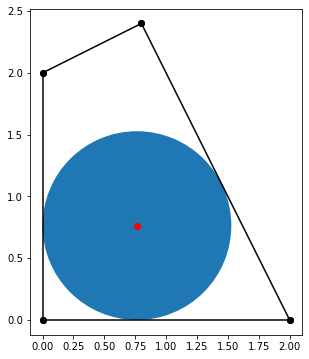

In [18]:
def chebyshev_center(A, b):
    n, m = A.shape

    x = cp.Variable(n)
    r = cp.Variable()

    objective = cp.Maximize(r)
    constraints = [A.T @ x + r * cp.sqrt(np.sum(A ** 2, 0)) <= b, r >= 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return x.value, r.value


center1, r1 = chebyshev_center(A1, b1)
plot_chebyshev_center2d(A1, b1, center1, r1)

assert center1.shape == (2,), "The center has the wrong shape"
assert np.abs(r1 - 0.763932) < 1e-4, "The radius for 2D case is not correct"
assert (
    np.abs(np.mean(center1) - 0.763932) < 1e-4
), "The center for 2D case is not correct"

center2, r2 = chebyshev_center(A2, b2)
assert (
    np.abs(np.mean(center2) + 0.333333) < 1e-4
), "The center for 3D case is not correct"
assert np.abs(r2 - 0.5) < 1e-4, "The radius for 3D case is not correct"
assert center2.shape == (3,), "The center has the wrong shape"